In [1]:
from utils_3_v1 import *
import pandas as pd
import numpy as np
import glob
from keras.utils import np_utils
import multiprocessing
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
path_to_midway = '/scratch/midway2/reshmask/' #change your scratch/home directory to save and load npy files
date           = '1003'
pool           = multiprocessing.Pool(processes=multiprocessing.cpu_count()) # multiprocessing initialization

### Loading metadata:
* Loading filtered mp3 audio speech files (52433, 8) - Refer to notebook 1

In [3]:
print('Loading metadata')
filtered_audios = pd.read_csv('FilteredMP3.csv')
filtered_audios['filename'] = filtered_audios['filename'].apply(lambda x: x.replace('.mp3','.wav'))
filtered_audios.shape

Loading metadata


(52433, 8)

### Create dummies for Gender and Age:
* Age dummies : 'seventies', 'thirties', 'twenties', 'sixties', 'fourties', 'fifties', 'teens', 'eighties'
* Gender dummies : 'male', 'female'

In [4]:
filtered_audios_dummies= pd.concat([filtered_audios['filename'],filtered_audios['accent'], pd.get_dummies(filtered_audios['gender']), pd.get_dummies(filtered_audios['age'])], axis=1)

In [5]:
print('Checking stats of accent')
filtered_audios_dummies['accent'].value_counts(normalize=True)

Checking stats of accent


us                0.288597
england           0.237789
canada            0.104591
indian            0.080274
australia         0.077680
scotland          0.052314
newzealand        0.042778
ireland           0.039326
african           0.034787
philippines       0.016364
singapore         0.010108
malaysia          0.006237
wales             0.004272
bermuda           0.002746
hongkong          0.001354
southatlandtic    0.000782
Name: accent, dtype: float64

### Filtered accent:
* Selected top 5 accents by looking at the distribution; 'US', 'England', 'Canada', 'Indian', 'Australia'
* Shape of the filtered file is 41366, 8
* Mapped accent category to number 

In [6]:
accent_dict = {'us':0, 'australia':1, 'england':2, 'indian':3, 'canada':4, 'scotland':5,
       'african':6, 'newzealand':7, 'ireland':8, 'bermuda':9, 'wales':10, 'malaysia':11,
       'philippines':12, 'hongkong':13, 'singapore':14, 'southatlandtic':15}
filtered_audios_dummies['accent'] = filtered_audios_dummies['accent'].map(accent_dict)
filtered_audios_dummies_accent    = filtered_audios_dummies[filtered_audios_dummies['accent'].isin([0, 1, 2, 3, 4])]
filtered_audios_dummies_accent.shape

(41366, 12)

In [12]:
filtered_audios_dummies_accent.columns

Index(['filename', 'accent', 'female', 'male', 'eighties', 'fifties',
       'fourties', 'seventies', 'sixties', 'teens', 'thirties', 'twenties'],
      dtype='object')

In [19]:
filtered_audios_dummies_accent['eighties'].value_counts(normalize=True)
#teen 0.068849, twenties 0.3152 thirties 22.72 fourties 14.86 fifties 15.20 sixties 5.988 seventies 2.5 eighties eighties 0.2

0    0.997051
1    0.002949
Name: eighties, dtype: float64

In [7]:
filtered_audios_dummies_accent = filtered_audios_dummies_accent[:100] #-- for testing purpose

### Seperate and split train, validation and test set:
* X = array of filenames, Y = array of top 5 accents
* Split train, val, test into 50%, 20% and 30%
* Stratified accent for all 3 sets to have equal distribution of y

In [8]:
X = filtered_audios_dummies_accent.drop('accent', axis=1)#['filename'].values
Y = filtered_audios_dummies_accent['accent'].values

In [9]:
X_, X_test, Y_, y_test = train_test_split(X, Y, test_size=0.30, random_state=99, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_, Y_, test_size=0.2855, random_state=99, stratify=Y_)

In [10]:
print ('shape of train file:', X_train.shape)
print ('shape of validation file:', X_val.shape)
print ('shape of test file:', X_test.shape)

shape of train file: (50, 11)
shape of validation file: (20, 11)
shape of test file: (30, 11)


### Read wav file for train and test:
* Multiprocessed both train and test data files
* Used librosa library to load wav files

In [11]:
print('Loading wav files....')
start_time  = time.time()
train_wav   = pool.map(get_wav, X_train['filename'].values)
val_wav     = pool.map(get_wav, X_val['filename'].values)
test_wav    = pool.map(get_wav, X_test['filename'].values)
print('total time for processing is:', (time.time()- start_time)/60.0)

Loading wav files....
total time for processing is: 1.1303913553555807


### Save train, test and validation wav file:
 * Saving y and X for train, test and validation

In [1]:
np.save(path_to_midway + 'train_wav.npy', train_wav)
np.save(path_to_midway + 'val_wav.npy', val_wav)
np.save(path_to_midway + 'test_wav.npy', test_wav)

np.save(path_to_midway + 'y_train.npy', y_train)
np.save(path_to_midway + 'y_test.npy', y_test)
np.save(path_to_midway + 'y_val.npy', y_val)

X_train.to_csv(path_to_midway+'X_train.csv', index=False)
X_test.to_csv(path_to_midway+'X_test.csv', index=False)
X_val.to_csv(path_to_midway+'X_val.csv', index=False)

### Load npy train, test and validation wav file:

In [14]:
train_wav = np.load('/scratch/midway2/reshmask/train_wav.npy', allow_pickle=True)
test_wav  = np.load('/scratch/midway2/reshmask/test_wav.npy', allow_pickle=True)
val_wav   = np.load('/scratch/midway2/reshmask/val_wav.npy', allow_pickle=True)

y_train   = np.load('/scratch/midway2/reshmask/y_train.npy', allow_pickle=True)
y_test    = np.load('/scratch/midway2/reshmask/y_test.npy', allow_pickle=True)
y_val     = np.load('/scratch/midway2/reshmask/y_val.npy', allow_pickle=True)

X_train   = pd.read_csv(path_to_midway+'X_train.csv')
X_test    = pd.read_csv(path_to_midway+'X_test.csv')
X_val     = pd.read_csv(path_to_midway+'X_val.csv')

### Trim log silences/pauses in train and test:

In [12]:
print('Trimming wav files....')
start_time  = time.time()
train_trim  = pool.map(trim_long_silences, train_wav)
val_trim    = pool.map(trim_long_silences, val_wav)
test_trim   = pool.map(trim_long_silences, test_wav)
print('total time for processing is:', (time.time()- start_time)/60.0)

Trimming wav files....
total time for processing is: 0.041356952985127766


### Feature extraction using Kaldi-toolkit:
* mfcc - 13 (12 cfpc coef, 1 energy)
* filterbank - 32
* delta_1, delta_2 - 64 each
* Frame level accent vector

In [13]:
print('Get Kaldi features....')
start_time      = time.time()
train_features, y_train_, train_len_  = get_kaldi_features(train_trim, y_train, X_train)
val_features, y_val_, val_len_        = get_kaldi_features(val_trim, y_val, X_val)
test_features, y_test_, test_len_     = get_kaldi_features(test_trim, y_test, X_test)
print('total time for processing is:', (time.time()- start_time)/60.0)

Get Kaldi features....
total time for processing is: 0.20721495946248372


In [19]:
# print('Get Kaldi features....')
# start_time = time.time()
# train_arr  = pool.starmap(get_kaldi_features, zip(train_trim, y_train, X_train.values))
# val_arr    = pool.starmap(get_kaldi_features, zip(val_trim, y_val, X_val.values))
# test_arr   = pool.starmap(get_kaldi_features, zip(test_trim, y_test, X_test.values))
# print('total time for processing is:', (time.time()- start_time)/60.0)

Get Kaldi features....
total time for processing is: 0.9676302949587504


In [20]:
# print('Convert feature form....')
# start_time                            = time.time()
# train_features, y_train_, train_len_  = convert_feat_form(train_arr)
# val_features, y_val_, val_len_        = convert_feat_form(val_arr)
# test_features, y_test_, test_len_     = convert_feat_form(test_arr)
# print('total time for processing is:', (time.time()- start_time)/60.0)

Convert feature form....
total time for processing is: 0.002360359827677409


### Training a Model:
* conv1D

In [14]:
# batch_size  = 100 
# epochs      = 20 
nb_classes  = 5 
input_shape = (train_features.shape[1],1) 

In [15]:
Y_train    = np_utils.to_categorical(y_train_, nb_classes)
Y_val      = np_utils.to_categorical(y_val_, nb_classes)

xts        = train_features.shape
train_X    = np.reshape(train_features, (xts[0], xts[1], 1))
xtv        = val_features.shape
val_X      = np.reshape(val_features, (xtv[0], xtv[1], 1))
xtt        = test_features.shape
test_X     = np.reshape(test_features, (xtt[0], xtt[1], 1))

In [16]:
model_history, nn_1d = train_conv1D_model(train_X, Y_train, val_X, Y_val, input_shape)

Train on 21109 samples, validate on 7903 samples
Epoch 1/20
21109/21109 [==============================] - 29s 1ms/step - loss: 1.5311 - convo_f1_score: 0.2422 - val_loss: 1.2528 - val_convo_f1_score: 0.3228
Epoch 2/20
21109/21109 [==============================] - 26s 1ms/step - loss: 1.2048 - convo_f1_score: 0.4728 - val_loss: 1.1286 - val_convo_f1_score: 0.2303
Epoch 3/20
21109/21109 [==============================] - 26s 1ms/step - loss: 1.1425 - convo_f1_score: 0.4139 - val_loss: 1.1655 - val_convo_f1_score: 0.4020
Epoch 4/20
21109/21109 [==============================] - 28s 1ms/step - loss: 1.0691 - convo_f1_score: 0.4672 - val_loss: 1.2007 - val_convo_f1_score: 0.4379
Epoch 5/20
21109/21109 [==============================] - 28s 1ms/step - loss: 0.9906 - convo_f1_score: 0.5384 - val_loss: 1.2509 - val_convo_f1_score: 0.4805
Epoch 00005: early stopping


In [17]:
model_history.history.keys()

dict_keys(['val_loss', 'val_convo_f1_score', 'loss', 'convo_f1_score'])

plotting train and test accuracy/f1-score/loss


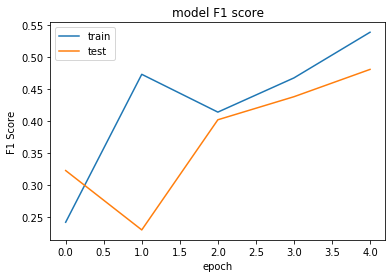

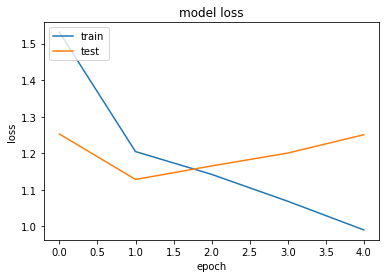

In [19]:
print('plotting train and test accuracy/f1-score/loss')
# summarize history for accuracy
plt.plot(model_history.history['convo_f1_score'])
plt.plot(model_history.history['val_convo_f1_score'])
plt.title('model F1 score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(path_to_midway+'f1_score.png'.format(date),bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(path_to_midway+'loss.png'.format(date), bbox_inches='tight')
plt.show()

### Save conv1D model

In [ ]:
print ('saving a model file')
nn_1d.save(path_to_midway+"nn_conv1d.h5")

### Prediction for test set:
* Calculate frame level accuracy

In [20]:
y_pred_test     = nn_1d.predict(test_X)
y_pred_test_cls = np.argmax(y_pred_test, axis=1)

In [21]:
y_pred_val     = nn_1d.predict(val_X)
y_pred_val_cls = np.argmax(y_pred_val, axis=1)

In [22]:
y_pred_train     = nn_1d.predict(train_X) 
y_pred_train_cls = np.argmax(y_pred_train, axis=1)

In [23]:
print ('Frame level accuracy for train set:', accuracy_score(y_train_, y_pred_train_cls))

Frame level accuracy for train set: 0.5983703633521247


In [24]:
print ('Frame level accuracy for val set:', accuracy_score(y_val_, y_pred_val_cls))

Frame level accuracy for val set: 0.5082879919018094


In [25]:
print ('Frame level accuracy for test set:', accuracy_score(y_test_, y_pred_test_cls))

Frame level accuracy for test set: 0.4739549839228296


### Get speaker level accuracy:
* Combine frame level accent ouput to find a major accent label for a speaker

In [26]:
y_pred_train_cls_sp = get_speaker_pred(train_len_['frame_len'].values, y_pred_train_cls)
y_pred_test_cls_sp  = get_speaker_pred(test_len_['frame_len'].values, y_pred_test_cls)
y_pred_val_cls_sp   = get_speaker_pred(val_len_['frame_len'].values, y_pred_val_cls)

In [27]:
print ('Speaker level accuracy for train:', accuracy_score(train_len_['accent'], y_pred_train_cls_sp))

Speaker level accuracy for train: 0.56


In [28]:
print ('Speaker level accuracy for val:',   accuracy_score(val_len_['accent'], y_pred_val_cls_sp))

Speaker level accuracy for val: 0.5


In [29]:
print ('Speaker level accuracy for test:',  accuracy_score(test_len_['accent'], y_pred_test_cls_sp))

Speaker level accuracy for test: 0.5


In [32]:
print ('saving classification reports at speaker level..')
save_report('nn1d_train',train_len_['accent'], y_pred_train_cls_sp)
save_report('nn1d_val',val_len_['accent'], y_pred_val_cls_sp)
save_report('nn1d_test',test_len_['accent'], y_pred_test_cls_sp)

saving classification reports at speaker level..


In [33]:
all_classes = ['US', 'Australia', 'England', 'Indian', 'Canada']

saving confusion matrix at speaker level..


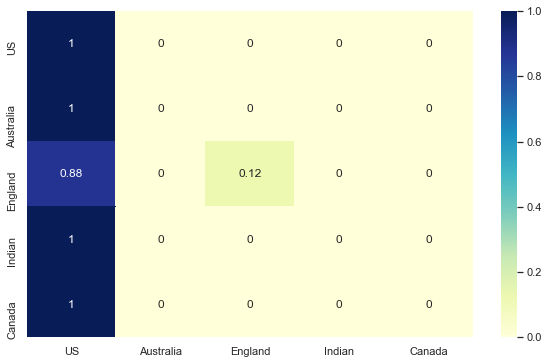

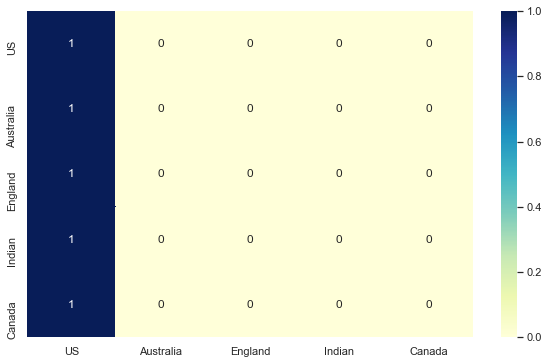

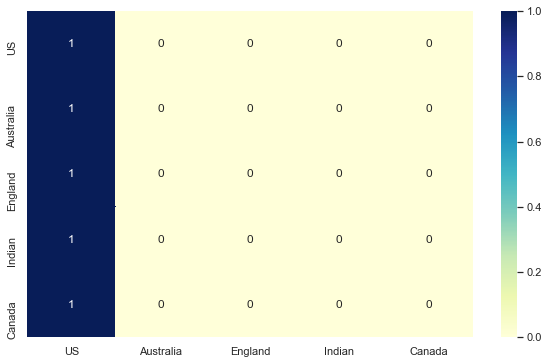

In [34]:
print ('saving confusion matrix at speaker level..')
save_cm('nn1d_train_cm',train_len_['accent'], y_pred_train_cls_sp, all_classes)
save_cm('nn1d_val_cm',val_len_['accent'], y_pred_val_cls_sp, all_classes)
save_cm('nn1d_test_cm',test_len_['accent'], y_pred_test_cls_sp, all_classes)

In [ ]:
# Frame level accuracy for train set: 0.8274350195402107
# Frame level accuracy for val set: 0.7432034065709191
# Frame level accuracy for test set: 0.7424890623253455
# Speaker level accuracy for train: 0.9350360373433948
# Speaker level accuracy for val: 0.8380963913780577
# Speaker level accuracy for test: 0.8385223423132764

In [17]:
# nn_blstm = train_blstm_model(train_X, Y_train, val_X, Y_val, input_shape)

C:\Users\SSK\Documents\UC - MScA\Courses\04-Spring_2020\04-DeepLearning\Project\data_to_explore\utils_3_v1.py:270: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(train_X, Y_train, batch_size=batch_size, nb_epoch=5, validation_data=(val_X, Y_val))


Train on 21109 samples, validate on 7903 samples
Epoch 1/5
21109/21109 [==============================] - 374s 18ms/step - loss: 1.2914 - accuracy: 0.4977 - val_loss: 1.1550 - val_accuracy: 0.4968
Epoch 2/5
21109/21109 [==============================] - 470s 22ms/step - loss: 1.2136 - accuracy: 0.5269 - val_loss: 1.1403 - val_accuracy: 0.4913
Epoch 3/5
21109/21109 [==============================] - 770s 36ms/step - loss: 1.1931 - accuracy: 0.5264 - val_loss: 1.1434 - val_accuracy: 0.4896
Epoch 4/5
21109/21109 [==============================] - 962s 46ms/step - loss: 1.1597 - accuracy: 0.5284 - val_loss: 1.1735 - val_accuracy: 0.4797
Epoch 5/5
21109/21109 [==============================] - 1057s 50ms/step - loss: 1.1072 - accuracy: 0.5441 - val_loss: 1.2164 - val_accuracy: 0.4954
